In [2]:
import pydicom
import open3d as o3d
import glob
import numpy as np
import copy

# Axial loading example

In [3]:
paths = [glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/*.dcm"), 
         glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/1054713880/*.dcm"),
         glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/2448190387/*.dcm")]

In [4]:
pydicom.read_file(paths[0][0])

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 4003253.1.15
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 4003253.1.15
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223717.543047'
(0008, 103e) Series Description                  LO: 'T2'
(0010, 0020) Patient ID                          LO: '4003253'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.8'
(0018, 5100) Patient Position                 

In [32]:
pcds_xyz = []
pcds_d = []

for index, series in enumerate(paths):
    for path in series:
        slice = pydicom.read_file(path)
        img = np.expand_dims(slice.pixel_array, -1)
        pcd = o3d.geometry.PointCloud()
        
        x,y,z=np.where(img)
        
        index_voxel=np.vstack((x,y,z))
        grid_index_array=index_voxel.T
        pcd.points = o3d.utility.Vector3dVector(grid_index_array)
        
        vals = np.array([img[x,y,z] for x,y,z in grid_index_array]) 
        
        dX, dY = slice.PixelSpacing
        X = np.array(list(slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(slice.ImageOrientationPatient[3:]) + [0]) * dY
        S = np.array(list(slice.ImagePositionPatient) + [1])
        
        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transformed_pcd = pcd.transform(transform_matrix)
                
        if index == 2:
            R = o3d.geometry.get_rotation_matrix_from_axis_angle([np.radians(90), np.radians(90), np.radians(90)])
            obb = transformed_pcd.get_oriented_bounding_box()
            transformed_pcd.rotate(R)
            
        pcds_xyz.extend(transformed_pcd.points)
        pcds_d.extend(vals)

RuntimeError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull Qt
Options selected for Qhull 2020.2.r 2020/08/31:
  run-id 1261948896  Qtriangulate  _pre-merge  _zero-centrum  _max-width 2e+02
  Error-roundoff 5.8e-13  _one-merge 4.1e-12  _near-inside 2e-11
  Visible-distance 1.2e-12  U-max-coplanar 1.2e-12  Width-outside 2.3e-12
  _wide-facet 7e-12  _maxoutside 4.7e-12

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p64028(v4):    32 1.7e+02 -4.5e+02
- p0(v3):   -95   -26 -4.4e+02
- p97168(v2): 1e+02   -24 -4.4e+02
- p318(v1):   -95 1.7e+02 -4.4e+02

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 5.8e-13.  The center point, facets and distances
to the center point are as follows:

center point   -14.52    72.71   -443.4

facet p0 p97168 p318 distance= -6.2e-14
facet p64028 p97168 p318 distance= -7e-14
facet p64028 p0 p318 distance= 7e-14
facet p64028 p0 p97168 distance= 1.3e-13

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:    -94.98       100  difference=  195
  1:     -26.5     172.2  difference= 198.7
  2:    -445.7  -2.225e-308  difference= 445.7

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 5.8e-13.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


In [30]:
pcd_overall = o3d.geometry.PointCloud()
pcd_overall.points = o3d.utility.Vector3dVector(pcds_xyz)
pcd_overall.colors.extend(o3d.utility.Vector3dVector(np.repeat(np.expand_dims(pcds_d, -1) / 256, 3, -1)))

In [31]:
o3d.visualization.draw_geometries([pcd_overall])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [58]:
voxel_grid = o3d.geometry.VoxelGrid().create_from_point_cloud(pcd_overall, dX)
o3d.visualization.draw_geometries([voxel_grid])

RuntimeError: [1;31m[Open3D Error] (virtual VoxelGrid &open3d::geometry::VoxelGrid::Rotate(const Eigen::Matrix3d &, const Eigen::Vector3d &)) /Users/renes/development/open3d_work/Open3D/cpp/open3d/geometry/VoxelGrid.cpp:116: Not implemented
[0;m

In [8]:
voxels = voxel_grid.get_voxels()

In [9]:
voxels[0]

Voxel with grid_index: (75, 160, 213), color: (0.125, 0.125, 0.125)

In [10]:
coords, vals = (np.array([voxel.grid_index for voxel in voxels]), 
                 np.array([voxel.color[0] for voxel in voxels]))


In [11]:
len(coords), len(vals)

(4079265, 4079265)

In [12]:
coords[0], voxel_grid.get_voxel_center_coordinate(coords[0])

(array([ 75, 160, 213], dtype=int32),
 array([ -52.48106122,   72.96211849, -447.29552278]))

In [13]:
size = np.max(coords, axis=0) + 1
grid = np.zeros((size[1], size[0], size[2]))

size, grid.shape

(array([321, 351, 329], dtype=int32), (351, 321, 329))

In [14]:
for index, coord in enumerate(coords):
    grid[(coord[1], coord[0], coord[2])] = vals[index] 

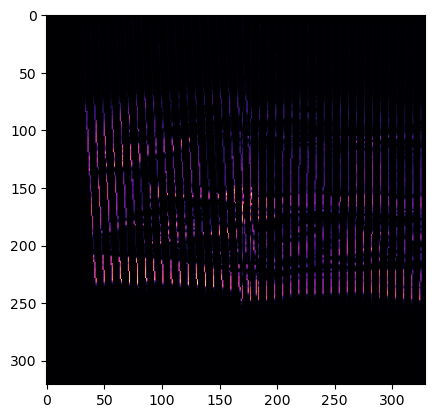

In [15]:
import matplotlib.pyplot as plt
plt.imshow(grid[150,:,:], cmap="magma")
plt.show()

In [16]:
from rsna_dataloader import read_series_as_pcd, read_series_as_voxel_grid

series = read_series_as_voxel_grid("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/3687121182")
#series = read_series_as_pcd("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/2448190387/")

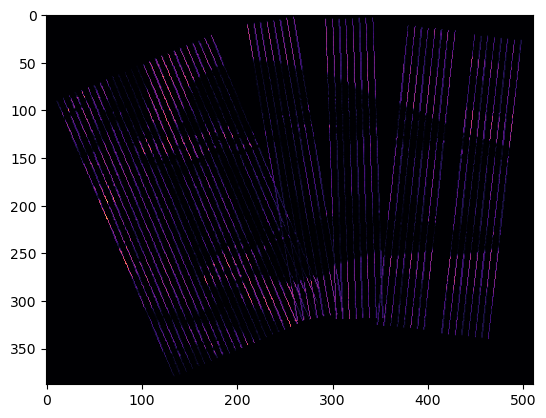

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(series[150,:], cmap="magma")

In [18]:
import open3d as o3d

x, y, z = np.where(series)

index_voxel = np.vstack((x, y, z))
grid_index_array = index_voxel.T

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(grid_index_array)
vals = np.array([series[x, y, z] for x, y, z in grid_index_array])
pcd.colors = o3d.utility.Vector3dVector(np.repeat(np.expand_dims(vals, -1) / 256, 3, -1))

In [19]:
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
